In [1]:
#Dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


In [2]:
#load in datasets
matches = pd.read_csv("epl_matches.csv", index_col=0) 
matches

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,2023-08-12,12:30,Premier League,Matchweek 1,Sat,Home,W,2.0,1.0,Nott'ham Forest,...,Match Report,NaN,15.0,7.0,19.1,0.0,0,0,2024,Arsenal
2,2023-08-21,20:00,Premier League,Matchweek 2,Mon,Away,W,1.0,0.0,Crystal Palace,...,Match Report,NaN,13.0,2.0,16.4,0.0,1,1,2024,Arsenal
3,2023-08-26,15:00,Premier League,Matchweek 3,Sat,Home,D,2.0,2.0,Fulham,...,Match Report,NaN,18.0,9.0,13.8,0.0,1,1,2024,Arsenal
4,2023-09-03,16:30,Premier League,Matchweek 4,Sun,Home,W,3.0,1.0,Manchester Utd,...,Match Report,NaN,17.0,5.0,15.0,0.0,0,0,2024,Arsenal
5,2023-09-17,16:30,Premier League,Matchweek 5,Sun,Away,W,1.0,0.0,Everton,...,Match Report,NaN,13.0,4.0,17.4,0.0,0,0,2024,Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,2019-04-13,12:30,Premier League,Matchweek 34,Sat,Away,L,0.0,4.0,Tottenham,...,Match Report,NaN,7.0,1.0,18.9,1.0,0,0,2019,Huddersfield Town
36,2019-04-20,15:00,Premier League,Matchweek 35,Sat,Home,L,1.0,2.0,Watford,...,Match Report,NaN,13.0,3.0,18.1,1.0,0,0,2019,Huddersfield Town
37,2019-04-26,20:00,Premier League,Matchweek 36,Fri,Away,L,0.0,5.0,Liverpool,...,Match Report,NaN,5.0,1.0,21.6,0.0,0,0,2019,Huddersfield Town
38,2019-05-05,14:00,Premier League,Matchweek 37,Sun,Home,D,1.0,1.0,Manchester Utd,...,Match Report,NaN,7.0,3.0,19.0,1.0,0,0,2019,Huddersfield Town


In [3]:
#convert date to date-time
matches["date"] = pd.to_datetime(matches["date"])


In [4]:
# setting the venue code

matches["venue_code"] = matches["venue"].astype("category").cat.codes

# 0 = away 
# 1 = home

In [5]:
# Create numeric codes for each unique 'opponent' value and store them in a new column 'opp_code'.
matches["opp_code"] = matches["opponent"].astype("category").cat.codes


In [6]:
# Create numeric codes for each unique 'team' value and store them in a new column 'team_code'.
matches["team_code"] = matches["team"].astype("category").cat.codes

In [7]:
# Extract the hour component from the 'time' column and store it as integers in a new column named 'hour'.
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")


In [8]:
# Add a new column 'day_code' to the 'matches' DataFrame, containing the day of the week from the 'date' column.
matches["day_code"] = matches["date"].dt.dayofweek


In [9]:
#target will be if team won lost or drawn
conditions = [
    (matches["result"] == "W"),  # Win condition
    (matches["result"] == "L"),  # Lose condition
    (matches["result"] == "D")   # Draw condition
]

values = [1, -1, 0,]  # 1 for win, -1 for lose, 0 for draw
matches["target"] = np.select(conditions, values, default=np.nan)
# # Apply np.select to create the 'target' column based on the defined conditions and values



In [10]:
#convert poss from an int to a percentage represented as a float
matches["poss"] = matches["poss"]/100


In [12]:
## This function calculates the rolling stats for Team, and Opponent, and the comparison stats between the team and the opponent.
## The function takes two arguments: the 'matches' DataFrame and the 'window' size.
## The function returns the 'matches' DataFrame with the calculated stats.
## to change the window size,(number of previous matches to include) change the value of the 'window' argument in the function call.

def calculate_rolling_stats(matches, window):
    # Sort the DataFrame by team and date
    matches = matches.sort_values(['team', 'date'])

    # Calculate rolling statistics for the team
    matches['last_{}_results'.format(window)] = matches.groupby('team')['target'].rolling(window).sum().reset_index(0, drop=True)
    matches['last_{}_gf'.format(window)] = matches.groupby('team')['gf'].rolling(window).sum().reset_index(0, drop=True)
    matches['last_{}_ga'.format(window)] = matches.groupby('team')['ga'].rolling(window).sum().reset_index(0, drop=True)
    matches['last_{}_avg_poss'.format(window)] = matches.groupby('team')['poss'].rolling(window).mean().reset_index(0, drop=True)
    matches['last_{}_avg_sot'.format(window)] = matches.groupby('team')['sot'].rolling(window).mean().reset_index(0, drop=True)
    
    # Sort the DataFrame by opponent and date
    matches = matches.sort_values(['opponent', 'date'])

    # Calculate rolling statistics for the opponent
    matches['opp_last_{}_results'.format(window)] = matches.groupby('opponent')['target'].rolling(window).sum().reset_index(0, drop=True)
    matches['opp_last_{}_gf'.format(window)] = matches.groupby('opponent')['ga'].rolling(window).sum().reset_index(0, drop=True)
    matches['opp_last_{}_ga'.format(window)] = matches.groupby('opponent')['gf'].rolling(window).sum().reset_index(0, drop=True)
    matches['opp_last_{}_avg_poss'.format(window)] = matches.groupby('opponent')['poss'].rolling(window).mean().reset_index(0, drop=True)
    matches['opp_last_{}_avg_sot'.format(window)] = matches.groupby('opponent')['sot'].rolling(window).mean().reset_index(0, drop=True)

    # Calculate the difference between team and opponent stats
    matches['last_{}_gd'.format(window)] = matches['last_{}_gf'.format(window)] - matches['last_{}_ga'.format(window)]
    matches['opp_last_{}_gd'.format(window)] = matches['opp_last_{}_gf'.format(window)] - matches['opp_last_{}_ga'.format(window)]
    matches['last_{}_gd_diff'.format(window)] = matches['last_{}_gd'.format(window)] - matches['opp_last_{}_gd'.format(window)]
    matches['last_{}_avg_poss_diff'.format(window)] = matches['last_{}_avg_poss'.format(window)] - matches['opp_last_{}_avg_poss'.format(window)]
    matches['last_{}_avg_sot_diff'.format(window)] = matches['last_{}_avg_sot'.format(window)] - matches['opp_last_{}_avg_sot'.format(window)]
   
    return matches

matches = calculate_rolling_stats(matches, 3)
matches.head()


,date,time,comp,round,day,venue,result,gf,ga,opponent,...,opp_last_3_results,opp_last_3_gf,opp_last_3_ga,opp_last_3_avg_poss,opp_last_3_avg_sot,last_3_gd,opp_last_3_gd,last_3_gd_diff,last_3_avg_poss_diff,last_3_avg_sot_diff
1,2018-08-12,16:00,Premier League,Matchweek 1,Sun,Away,W,2.0,0.0,Arsenal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-08-18,17:30,Premier League,Matchweek 2,Sat,Home,W,3.0,2.0,Arsenal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-08-25,15:00,Premier League,Matchweek 3,Sat,Away,L,1.0,3.0,Arsenal,...,1.0,5.0,6.0,0.530000,8.000000,-7.0,-1.0,-6.0,-0.076667,-4.333333
4,2018-09-02,13:30,Premier League,Matchweek 4,Sun,Home,L,2.0,3.0,Arsenal,...,-1.0,8.0,6.0,0.430000,6.333333,-1.0,2.0,-3.0,-0.023333,-4.000000
5,2018-09-15,15:00,Premier League,Matchweek 5,Sat,Home,L,1.0,2.0,Arsenal,...,-3.0,8.0,4.0,0.346667,3.333333,-3.0,4.0,-7.0,-0.083333,-1.333333


In [13]:
# fill the NaN values in the dataframe columns with the median value of those columns

columns_to_fill = [
    'last_3_results', 'opp_last_3_results',
    'last_3_gf', 'opp_last_3_ga',
    'last_3_gd', 'opp_last_3_gd',
    'last_3_gd_diff', 'last_3_ga',
    'opp_last_3_gf', 'opp_last_3_avg_poss',
    'last_3_avg_poss', 'last_3_avg_poss_diff',
    'opp_last_3_avg_sot', 'last_3_avg_sot',
    'last_3_avg_sot_diff','last_3_gd',
]

for column in columns_to_fill:
    median_value = matches[column].median()
    matches[column].fillna(median_value, inplace=True)

matches.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,opp_last_3_results,opp_last_3_gf,opp_last_3_ga,opp_last_3_avg_poss,opp_last_3_avg_sot,last_3_gd,opp_last_3_gd,last_3_gd_diff,last_3_avg_poss_diff,last_3_avg_sot_diff
1,2018-08-12,16:00,Premier League,Matchweek 1,Sun,Away,W,2.0,0.0,Arsenal,...,0.0,4.0,4.0,0.503333,4.000000,0.0,0.0,0.0,-0.003333,0.000000
2,2018-08-18,17:30,Premier League,Matchweek 2,Sat,Home,W,3.0,2.0,Arsenal,...,0.0,4.0,4.0,0.503333,4.000000,0.0,0.0,0.0,-0.003333,0.000000
2,2018-08-25,15:00,Premier League,Matchweek 3,Sat,Away,L,1.0,3.0,Arsenal,...,1.0,5.0,6.0,0.530000,8.000000,-7.0,-1.0,-6.0,-0.076667,-4.333333
4,2018-09-02,13:30,Premier League,Matchweek 4,Sun,Home,L,2.0,3.0,Arsenal,...,-1.0,8.0,6.0,0.430000,6.333333,-1.0,2.0,-3.0,-0.023333,-4.000000
5,2018-09-15,15:00,Premier League,Matchweek 5,Sat,Home,L,1.0,2.0,Arsenal,...,-3.0,8.0,4.0,0.346667,3.333333,-3.0,4.0,-7.0,-0.083333,-1.333333


In [14]:
# #random forest classifier
# # Define the list of predictors including venue code, opponent code, hour, and day code.
predictors = ["venue_code", "opp_code", "hour", "day_code", 'team_code',
'last_3_results',
'last_3_gf',
'last_3_ga',
'last_3_avg_poss',
'opp_last_3_results',
'opp_last_3_gf',
'opp_last_3_ga',
'opp_last_3_avg_poss',
'last_3_gd',
'opp_last_3_gd',
'last_3_gd_diff',
'last_3_avg_poss_diff',]

# # Define the features (predictors) and the target variable
X = matches[predictors]
y = matches["target"]

# # Split the data into training and testing sets with a ratio of 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# # Initialize a Random Forest classifier with 50 trees, minimum samples split of 10, and a fixed random state.
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, random_state=1)

# # Train the Random Forest classifier on the training data using specified predictors.
rf_model = rf_model.fit(X_train, y_train)

In [15]:
# Generate predictions using the trained Random Forest classifier on the test data using specified predictors.
# # Train the Random Forest classifier on the training data using specified predictors.
preds = rf_model.predict(X_test)


In [16]:
# Evaluate the best model on the training set
train_accuracy = rf_model.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# Evaluate the best model on the test set
test_accuracy = rf_model.score(X_test, y_test)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.8776178010471204
Testing Accuracy: 0.7183206106870229


In [17]:
# Create a contingency table showing the counts of actual versus predicted labels
combined = pd.DataFrame({"actual": y_test, "prediction": preds})
pd.crosstab(index=combined["actual"], columns=combined["prediction"])

prediction,-1.0,0.0,1.0
actual,,,
-1.0,442,21,52
0.0,105,79,131
1.0,37,23,420


In [18]:
# determine which feature explains the most variance in the model
importances = rf_model.feature_importances_
# return the original feature names
feature_names = X.columns
#create a DataFrame to display the feature importance
feature_importance = pd.DataFrame({"feature": feature_names, "importance": importances})
feature_importance

,feature,importance
0,venue_code,0.008203
1,opp_code,0.024993
2,hour,0.015600
3,day_code,0.010896
4,team_code,0.024994
5,last_3_results,0.170021
6,last_3_gf,0.035503
7,last_3_ga,0.034326
8,last_3_avg_poss,0.037535
9,opp_last_3_results,0.161096


<Axes: xlabel='importance', ylabel='feature'>

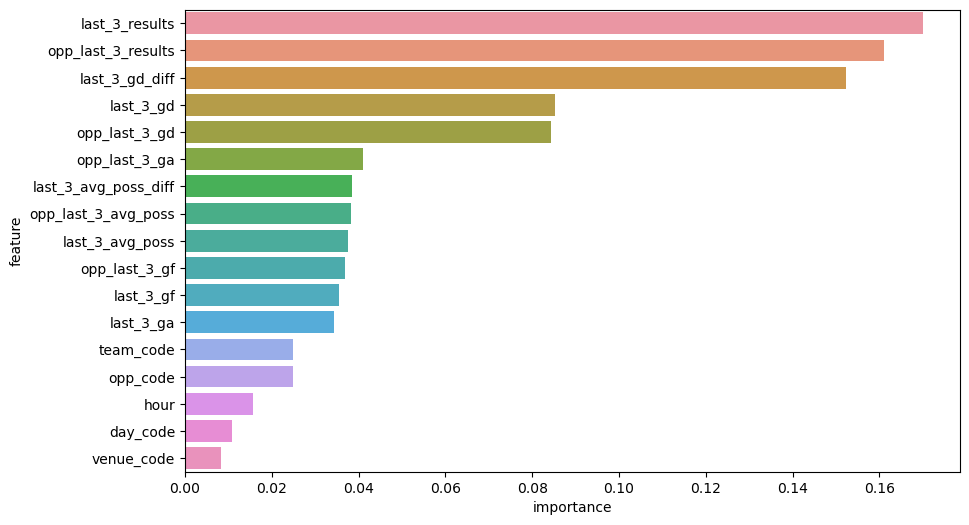

In [19]:
#create a bar plot to visualize the feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importance.sort_values(by="importance", ascending=False))

In [20]:
# Generate classification report
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

        -1.0       0.76      0.86      0.80       515
         0.0       0.64      0.25      0.36       315
         1.0       0.70      0.88      0.78       480

    accuracy                           0.72      1310
   macro avg       0.70      0.66      0.65      1310
weighted avg       0.71      0.72      0.69      1310

